# Impacts of the 2017 Thomas Fire

The 2017 Thomas Fire in Santa Barbara and Ventura County, was one of the largest fires in California's history with over 280,000 acres burned. By looking at the Air Quality Index (AQI) and fire scars resulting from the fire, we can begin to visualize its devastating effects. 

View more information and additional data exploration located on my Github.
[View the full repository here](https://github.com/emmabeamitchell/Thomas_Fire_2017)

<img title="Thomas Fire credit of Ray Ford / Noozhawk" alt="Picture of the Thomas Fire" src="https://news.ucsb.edu/sites/default/files/styles/large_2340x1212/public/2023-11/Thomas-Fire-Faria-Beach-cropped-Noozhawk.jpg?itok=YGnOu1vN" width = 400>

Credit to Ray Ford/ Noozhawk

### About the Project

The purpose of this project is to analyze both AQI and Landsat data from the Santa Barbara County area to explore the fire's effects. 

First, we look at AQI data from 2017 and 2018, subsetting specifically for Santa Barbara County, and creating a rolling mean, which allows us to create a graph visualizing the spike is Air Quality Index at the time of the fire. 

Second, we explore Landsat data, using both true and false color imagery to show the benefits of using false color imagery. We used the Landsat data, combined with the Thomas Fire data to map the effects of the fire. 


Highlights include

- date and string data wrangling
- visualizing time series
- use of the `.rolling` function to find averages
- use of `.loc` for spatial subsetting
- use of `.squeeze` and `.drop_vars` to remove bands
- load and explore data with `rioxr.open_rasterio()`
- clip one dataset to another using `.rio.clip_box`
- creation of true and false imagery
- crs transformation

### About the data

The AQI data is updated twice a year by the Environmental Protection Agency (EPA). It contains Air Quality Index data by day, year, and county. It is from a collection of pregenerated data from outdoor monitors across the US. The data was retrieved from [the EPA website](https://aqs.epa.gov/aqsweb/airdata/download_files.html)

The Landsat data is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. The data was retrieved from the [Microsoft Planetary Computer Data Catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and pre-processed to remove data outside land and coarsen the spatial resolution. 

The Thomas fire data is a subset of the shapefile from [California Fires (all) from Data.gov](https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436), which contains fire data for all of California. This data is updated annualy by The California Department of Forestry and Fire Protection's Fire and Resource Assessment Program.


## Air Quality Index During Thomas Fire

Air Quality Index is determined by the concentrations of pollutants in the air, and has a range of values that determine health

- Good (green): 0 to 50
- Moderate (yellow): 51 to 100
- Unhealthy for sensitive groups (orange): 101 to 150
- Unhealthy (red): 151 to 200
- Very unhealthy (purple): 201 to 300
- Hazardous (maroon): 300 +

By plotting the AQI of before, during, and after the Thomas Fire, we can view one of the fire's important effects on people and the environment.

#### Set up our data

Load in the necessary packages to run our analysis

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.patches as mpatches

Read in data for the Air Quality Index in 2017 and 2018 using `pandas` to create `pandas.DataFrames`

In [2]:
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip", compression = 'zip')
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip", compression = 'zip')

We currently have two separate data frames for two separate years. Combining them using the `.concat` pandas function allows us to "glue" the data together into one `pandas.DataFrame`

In [3]:
# Concatenate the two datasets to combine
aqi = pd.concat([aqi_17, aqi_18])

#### Clean the data
Change column names to lower case and replace spaces with underscores for continuity and easier wrangling

In [4]:
# Clean column names
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# Print column names to confirm lower snake case change
print(aqi.columns)

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')


To effectively work with time series data, we need to make sure that the `date` column is set as a `pd.datetime` object. This ensures that python realizes that the `date` column corresponds to dates. We will then set the `date` column as the index to work with the time series data and easily plot it later on. 

In [5]:
# Change date column to datetime object
aqi.date = pd.to_datetime(aqi['date'])

In [6]:
# Set date as index
aqi = aqi.set_index('date')

#### Use our data
We actually only want to use a portion of the `aqi` dataset. We will subset the data for only Santa Barbara County because we are interested only in the effects of the Thomas Fire, which occured in that county.

In [7]:
# Subset county_name
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

Calculate the five day average of the AQI. We will do this using the `.rolling()` function, a lazy function that will allow us to calculate the `mean` over the given window. In this case we want to see the five day average. We will create a new column called `five_day_average` to keep this information in our dataframe.

In [22]:
aqi_sb.loc[:, 'five_day_average'] = aqi_sb['aqi'].rolling(window='5D').mean()

#### Plot the five day average

We will use `.plot()` to visualize the five day average and the daily AQI surrounding and during the Thomas Fire.

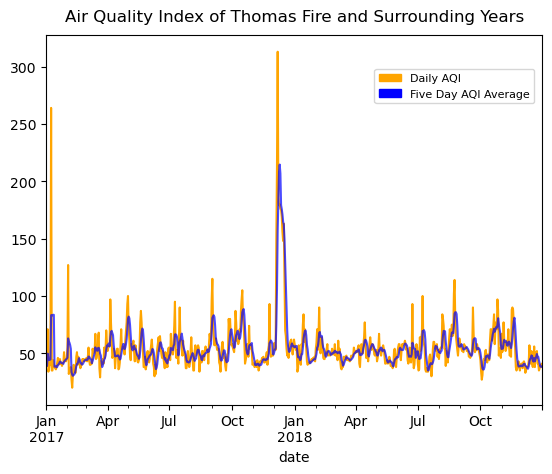

In [36]:

fig, ax = plt.subplots()
ax.set_title("Air Quality Index of Thomas Fire and Surrounding Years", 
             fontsize=12, loc='center', pad=10)
aqi_sb['aqi'].plot(ax=ax, 
                color='orange')
aqi_sb['five_day_average'].plot(ax=ax, 
                color='blue',
                alpha=0.7)
# Add a custom legend element manually
custom_patch = mpatches.Patch(color='orange', label='Daily AQI')

custom_patch_average = mpatches.Patch(color = 'blue', label = 'Five Day AQI Average')
# Add custom legend
ax.legend(handles=[custom_patch, custom_patch_average], loc='lower left', fontsize=8, frameon=True, bbox_to_anchor=(0.65, .8))
plt.show()


The Thomas Fire burned in December 2017 through January 2018. When looking at that time frame on our plot, we can clearly see how the fire significantly drove up the AQI. This makes sense, as a large fire releases many contaminants into the air, driving up the index. Recalling back to the AQI index number indications, we can see that the five day average during the fire got above 200, which is very unhealthy. It even appears that the daily AQI reached over 300, putting it into the highest and most hazardous category.  

## Landsat Data of Thomas Fire

The Landsat satellite has the ability to capture a collection of bands (red, green, blue, near-infrared and shortwave infrared) through data on reflected light. The appearance of each of these bands indicates the presence of different materials in the environment. Using false color imagery can help us visualize bands we cannot see with our naked eye, and better understand what they mean. 

<img title="Reflectance Spectra credit of NASA, ESA, Leah Hustak (STScI)" alt="Graph of reflectance spectra" src="https://stsci-opo.org/STScI-01F8QZ8NDAYKWN2WR30VQ45E4Z.jpg" width="400">

Credit to NASA, ESA, Leah Hustak (STScI)

#### Read in the fire data

We will be using our Landsat data to analyze fire scars from the Thomas Fire. In order to visualize these scars, it's helpful to have a boundary of the fire. Let's add in our fire data and filter it down to the 2017 Thomas Fire to use in our map later on. 

In [10]:
# Read in fire data
path = fp = os.path.join("data","California_Fire_Perimeters_(all).shp") 

perimeters = gpd.read_file(path) 

#### Brief exploration

Let's do some exploration into our data. It's always important to look at the CRS, ellipsoid, datum, and projection when we are going to combine multiple datasets. We want to make sure that all of our information is consistent before we combine them. Remember that we will combine this with our Landsat data later on. 

In [11]:
# Explore CRS
print(f"ellipsoid: {perimeters.crs.ellipsoid}")
print(f"datum: {perimeters.crs.datum}")
print(f"crs: {perimeters.crs}")
print(f"{'Is the CRS geographic?:':<25} {perimeters.crs.is_geographic}")
print(f"{'Is the CRS projected?:':<25} {perimeters.crs.is_projected}")

ellipsoid: WGS 84
datum: World Geodetic System 1984 ensemble
crs: EPSG:3857
Is the CRS geographic?:   False
Is the CRS projected?:    True


#### Select for Thomas Fire

We don't want fire data for the entire state, so let's select only for the Thomas Fire in 2017. We will use our filtered down fire data in our map alongside our Landsat data to visualize the Thomas Fire area. 

In [12]:
# Select for only the Thomas Fire 2017
thomas_fire = perimeters.loc[(perimeters['FIRE_NAME'] == "THOMAS") &
                                 (perimeters['YEAR_'] == 2017)]

#### Read in Landsat data

In [34]:
# Load in Landsat data 
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'hwk4_landsat_data')

fp = os.path.join(root,
                 'landsat8-2018-01-26-sb-simplified.nc')

landsat = rioxr.open_rasterio(fp)

# View Landsat 
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

Because this data is an xarray.Dataset, we can simply call `landsat` to see information about it. Its dimensions are x:870, y:731, with one band. The data variables are red, green, blue, nir08, swir22. We can see that there is only one band, so we can get rid of the band dimension

In [15]:
# Drop band dimensions and remove coordinates associated to band
landsat = landsat.squeeze()
landsat = landsat.drop_vars('band')
# Print to confirm results
print(landsat.dims, landsat.coords)

FrozenMappingWarningOnValuesAccess({'x': 870, 'y': 731}) Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0


### True Color Image

Using our Landsat data, we can now begin to look at fire scars from the 2017 Thomas Fire. First we will create a true color image, meaning that we will plot the landsat data in the correct colors that we would see in a normal image. The red = red, green = green, and blue = blue. This will help us get an idea of the map that we are working with and see how clear it is to see the fire scars normally.

Index the colors in order to create a true color image

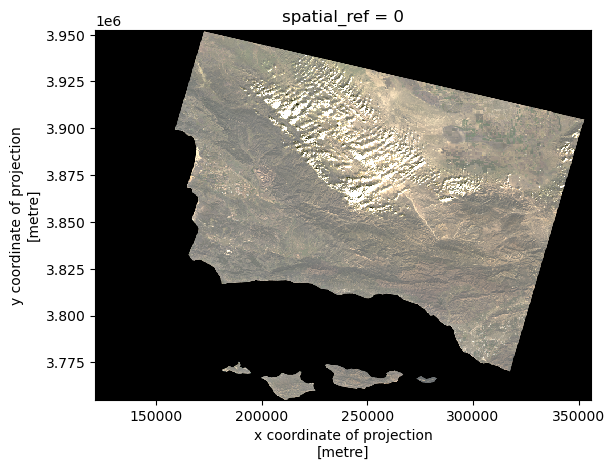

In [16]:
# Add robust = True to view true color RGB image
landsat[["red", "green", "blue"]].to_array().plot.imshow(robust = True)

With the true color image, our entire plot looks very monochromatic. It's not possible to see the effects of the Thomas Fire, as all of the land looks extremely similar. In order to get any information from our plot, we need to switch our image to false color.

## False color image

Our false color image will plot the short-wave infrared (swir22), near-infrared, and red variables (in that order).

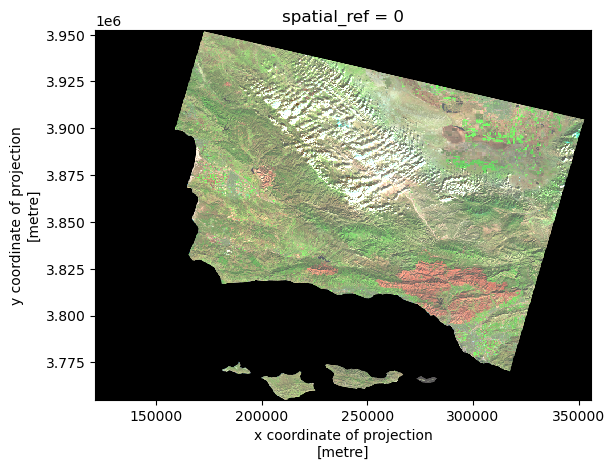

In [17]:
# Plot false color image
landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True)

## Map our false color imagery
We will create a map showing the shortwave infrared/near-infrared/red false color image together with the Thomas Fire. This will allow us to understand what fire scars we are seeing in the environment.

Whenever we combine spatial data we have to check that the CRSs match, and reproject if they do not.

In [18]:
# Examine CRss
print('thomas_fire CRS: ', thomas_fire.crs)
print('landsat CRS: ', landsat.rio.crs)

thomas_fire CRS:  EPSG:3857
landsat CRS:  EPSG:32611


In [19]:
# Reproject thomas_fire to landsat crs
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

In addition to layering the perimeter data on top of the Landsat data, we also want to "zoom in" on the area we are interested in. We will clip the Landsat data to the Thomas fire bounds using `.rio.clip_box()`

In [20]:
# Clip data
landsat_small = landsat.rio.clip_box(*thomas_fire.total_bounds)

Let's finally create a clean plot of our false color image. 

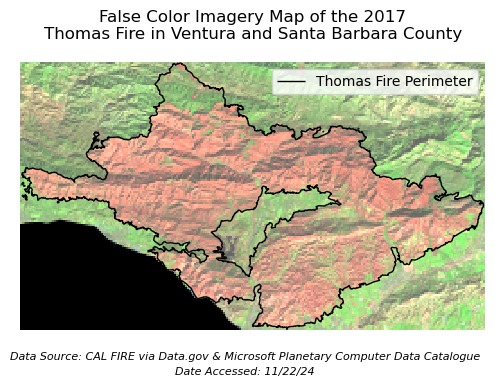

In [21]:
# Set aspect ratio
landsat_aspect_ratio = landsat.rio.width / landsat.rio.height

# Plot clipped data
fig, ax = plt.subplots(figsize=(6, 6 * landsat_aspect_ratio))  
landsat_small[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True, ax=ax)
thomas_fire.boundary.plot(ax=ax, linewidth=1, edgecolor='black', label = "Thomas Fire Perimeter")

ax.set_axis_off()
ax.set_title('False Color Imagery Map of the 2017\nThomas Fire in Ventura and Santa Barbara County')
fig.text(0.5, 0.27, 'Data Source: CAL FIRE via Data.gov & Microsoft Planetary Computer Data Catalogue', ha='center', va='center', fontsize=8, color='black', fontstyle='italic') 
fig.text(0.5, 0.25, 'Date Accessed: 11/22/24', ha='center', va='center', fontsize=8, color='black', fontstyle='italic')
ax.legend(loc='upper right')
fig.savefig('landsat_map_thomas_fire.png', dpi=300, bbox_inches='tight')
plt.show()

False color imagery is being used to show the scar from the 2017 Thomas Fire. We can see that the color is significantly different inside the Thomas Fire Perimeter. The difference in color indicates a difference in vegetation (ie. dead vs alive) which more easily shows us the effects of the Thomas Fire than a true color image would. 

**Let's break down the false color image**|

The red represents shortwave infrared wavelengths which is shown on the far right side of the figure, after the 2,000 nanometer mark. We can see that the shortwave infrared shows mostly dry soil. That means that where we are seeing red on our map, that is dry soil, meaning a lack of living vegetation.


The green represents near-infrared wavelengths, which is shown on the figure between wavelengths of 850 t0 880. We can see that the near-infrared wavelengths show mostly healthy vegetation. That means that where we are seeing green on our map, that is vegetation, meaning a lack of fire scars. 


The blue represents red. We don't see any blue in our image, so we do not need to worry about its reflectance. 

### References

Microsoft Planetary Computer Data Catalogue, Landsat collection 2 Level-2. Available from: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Access date: December 3rd, 2024.

Data.gov Data Catalogue, California Fire Perimeters (all). Available from: https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436. Access date: December 3rd, 2024.

AirData, US EPA. Available from:  https://aqs.epa.gov/aqsweb/airdata/download_files.html. Access date: December 3rd, 2024